In [1]:
!pip install keras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 7.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from keras import Sequential
from keras.layers import LSTM,Dense
from datetime import datetime, timedelta
from kerastuner import RandomSearch
from keras.metrics import MeanAbsolutePercentageError,RootMeanSquaredError
from keras_tuner import HyperModel
from keras_tuner import HyperParameters as hp
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
import seaborn as sns
import pytz #tratar zona hoaria de los datos

<ipython-input-3-dd6e6e0c7386>:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [4]:
from google.colab import drive

In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
import os
os.environ['Kaggle_config_dir']='/content/gdrive/MyDrive/Colab Notebooks/Kaggle'#

In [7]:
%cd /content/gdrive/MyDrive/Colab Notebooks/Kaggle

/content/gdrive/MyDrive/Colab Notebooks/Kaggle


In [8]:
#!ls

#Configuración de la red neuronal

In [9]:
class MyHypermodel(HyperModel):
  def __init__(self,entrada,salida):
    self.entrada=entrada
    self.salida=salida
  def build(self,hp):
    modelo=Sequential()
    modelo.add(LSTM(units=hp.Int('units_1',120,160,step=20),input_shape=self.entrada,return_sequences=True))
    modelo.add(LSTM(units=hp.Int('units_2',160,320,step=10),return_sequences=True))#
    modelo.add(LSTM(units=hp.Int('units_3',700,720,step=5)))
    modelo.add(Dropout(rate=hp.Float('r',0.09,0.2,step=0.025)))
    modelo.add(Dense(units=self.salida))
    modelo.compile(optimizer='adam',loss='mse',metrics=[RootMeanSquaredError(name='mse')])
    return modelo

  def fit(self,hp,modelo,*args,**kwargs):
    return modelo.fit(*args,validation_split=0.27, epochs=200,batch_size=35,**kwargs)


#Preprocesamiento de los datos

In [10]:
fed=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Kaggle/FRB_H15.csv')

In [11]:
fed.drop(0,axis=0,inplace=True)

In [12]:
fed.rename(columns={'H15/H15/RIFSPFF_N.WW':'R_US'},inplace=True)
fed.rename(columns={'Unique Identifier: ':'Fecha'},inplace=True)

In [13]:
tz=pytz.timezone('US/Eastern')

In [14]:
fed['Fecha']=pd.to_datetime(fed['Fecha'],utc=tz)
fed['R_US']=fed['R_US'].astype(float)

In [15]:
fed.set_index('Fecha',inplace=True)
fed=fed.asfreq('D',method='bfill').tz_convert('America/Bogota')
fed.index=pd.to_datetime(fed.index.strftime('%Y-%m-%d'))

In [16]:
fed.head()

,R_US
Fecha,
2000-01-04,4.72
2000-01-05,5.62
2000-01-06,5.62
2000-01-07,5.62
2000-01-08,5.62


In [17]:
dolar_y=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Kaggle/trm9.csv',sep=';')
dolar_y['Fecha']=pd.to_datetime(dolar_y['Fecha'])
dolar_y['COP/USD']=dolar_y['COP/USD'].replace(',','.',regex=True)
dolar_y['COP/USD']=dolar_y['COP/USD'].astype(float)

In [18]:
dolar_y=dolar_y.drop_duplicates()
dolar_y['anios']=dolar_y['Fecha'].dt.year

<ipython-input-18-6d5e9e38e99f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dolar_y['anios']=dolar_y['Fecha'].dt.year


In [19]:
datos=dolar_y[dolar_y['anios']>=2000]

In [20]:
datos.set_index('Fecha',inplace=True)
datos=datos.merge(fed,how='left',on='Fecha')
datos.sort_index(inplace=True)
datos=datos.asfreq('B',method='bfill')

In [21]:
datos.isna().sum()

COP/USD    0
anios      0
R_US       8
dtype: int64

In [22]:
datos['R_US']=datos['R_US'].asfreq('B',method='bfill')
del datos['anios']
datos.fillna(5.08,inplace=True)

In [23]:
datos.dtypes

COP/USD    float64
R_US       float64
dtype: object

In [24]:
normalizador=MinMaxScaler(feature_range=(0,1))
datos['R_US']=datos['R_US'].apply(lambda x:x/100)

In [25]:
datos=datos.iloc[:-2,:]#variar parametro

In [26]:
normalizador.fit(datos[['COP/USD']])

MinMaxScaler()

In [27]:
datos[['COP/USD']]=normalizador.transform(datos[['COP/USD']])

<ipython-input-27-0bbf2cafd8a8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos[['COP/USD']]=normalizador.transform(datos[['COP/USD']])


In [28]:
from statsmodels.graphics.tsaplots import plot_acf

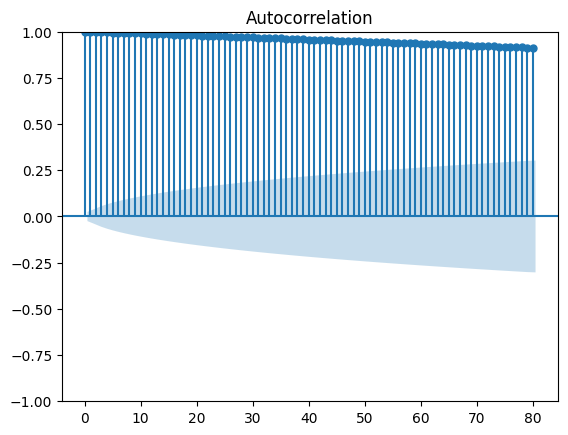

In [29]:
plot_acf(datos['COP/USD'],lags=80)
plt.show()

#Partición de los datos

In [30]:
datos=datos[datos.index>='2000-01-4']

In [31]:
 def particion_datos(datos): #,val=0.1,
  total=datos.shape[0]
  train=datos[datos.index<='2023-02-21']
  end=datos.index[-1]#+timedelta(1)
  test=datos[(datos.index>='2023-02-22')&(datos.index<=end)]#'2023-05-15'
  return train,test,end

In [32]:
datos.tail()

,COP/USD,R_US
Fecha,,
2023-06-14,0.743338,0.0508
2023-06-15,0.742173,0.0508
2023-06-16,0.736990,0.0508
2023-06-19,0.731433,0.0508
2023-06-20,0.731433,0.0508


In [33]:
train,test,end=particion_datos(datos)

In [34]:
lags=13
steps=8

In [35]:
def config_serie(datos,lags,steps):
  x,y=[],[]
  shape=datos.shape
  fila,col=datos.shape
  for i in range(fila-lags-steps+1):
    x.append(datos.iloc[i:i+lags,:])
    y.append(datos.iloc[i+lags:i+lags+steps,0])
  X=np.array(x)
  Y=np.array(y)
  return X,Y

In [36]:
len(test)

85

In [37]:
x_train,y_train=config_serie(train,lags,steps)#

In [38]:
x_test,y_test=config_serie(test,lags,steps)#los y_test inician  desde el 29/03/2023, desde el 22/02/2023 hasta el 29/03/2023 va los x_train

#Entrenamiento de modelo

In [39]:
hipmod=MyHypermodel((x_train.shape[1],2),y_train.shape[1])

In [40]:
tuner=RandomSearch(hipmod,objective=('val_mse'),max_trials=2, directory='busqueda_red_neuronal',project_name='LSTM_defX' )# SerieV 2013,SerieVer1 sin tasa de interes 35,5 LSTM_t7 12 5


Nombre del proyecto: 'LSTM_defX' 13 8

In [41]:
tuner.search(x_train,y_train)

In [42]:
tuner.results_summary()

Results summary
Results in busqueda_red_neuronal/LSTM_defX
Showing 10 best trials
Objective(name="val_mse", direction="min")

Trial 1 summary
Hyperparameters:
units_1: 120
units_2: 220
units_3: 705
r: 0.09
Score: 0.021318262442946434

Trial 0 summary
Hyperparameters:
units_1: 160
units_2: 300
units_3: 705
r: 0.19
Score: 0.022686919197440147


In [43]:
mod=tuner.get_best_models(num_models=1)[0]

#Prueba del modelo

In [44]:
def test_mod(modelo,x_test,y_test,normalizador,end,steps):
  pronostico_trm=modelo.predict(x_test)
  y_test=normalizador.inverse_transform(y_test)
  pronostico_trm=normalizador.inverse_transform(pronostico_trm)
  #harian falta los prnosticos de los ssteps -1
  adT=y_test[-1,range(1,steps)]
  adP=pronostico_trm[-1,range(1,steps)]
  a1=pd.DataFrame(adP,columns=['TRM Modelo'])
  b1=pd.DataFrame(adT,columns=['TRM Real'])
  ab=pd.concat([a1,b1],axis=1)

  #error de los prnosticos Día
  y_m=y_test[:,:]
  d_m=pronostico_trm[:,:]
  div=np.square(y_m-d_m)
  div=np.mean(div,axis=0)
  div=np.sqrt(div)
  fig,ax=plt.subplots()
  #Grafica de los errores entre pronósticos día
  ax.plot(div,'o--')
  ax.set_xlabel('Dia')
  ax.set_ylabel('Error ($)')
  ax.set_xticks([i for i in range(0,steps)],labels=[f"D{i+1}" for i in range(0,steps)])

  #Impresion de resultados
  y_test=y_test[:,[0]]
  pronostico_trm=pronostico_trm[:,[0]]
  a=pd.DataFrame(pronostico_trm,columns=['TRM Modelo'])
  RvsM=a
  b=pd.DataFrame(y_test,columns=['TRM Real'])
  RvsM=pd.concat([a,b],axis=1)
  RvsM=pd.concat([RvsM,ab],axis=0,ignore_index=False)

  fecha_test=pd.date_range(end=end,periods=len(RvsM),freq='B')
  RvsM.index=fecha_test
  metrica=mean_squared_error(y_m,d_m,squared=False)
  return RvsM,metrica,ax,div


3/3 [==============================] - 1s 36ms/step


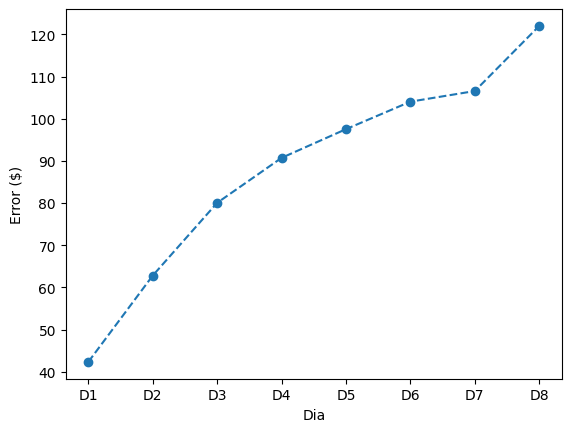

In [45]:
RvsM,mt,grafico,errores=test_mod(mod,x_test,y_test,normalizador,end,steps)

In [46]:
errores

array([ 42.34911668,  62.81559711,  80.05761701,  90.71982998,
        97.52683399, 104.04486543, 106.56416233, 121.99880514])

In [47]:
RvsM.tail()

,TRM Modelo,TRM Real
2023-06-14,4197.283691,4186.30
2023-06-15,4183.245117,4182.33
2023-06-16,4164.759766,4164.66
2023-06-19,4170.706543,4145.72
2023-06-20,4205.015137,4145.72


In [48]:
def pronostico_actual(datos,modelo,lags,steps):
  d=datos.iloc[-lags:,:]
  x_act=np.array([d]).reshape(1,lags,2)
  pronost=modelo.predict(x_act)
  pronost=normalizador.inverse_transform(pronost)
  s=datos.iloc[-1,:].name
  ini=s+timedelta(1)
  fechas=pd.date_range(start=ini,periods=pronost.shape[1],freq='B')
  pronost=pd.DataFrame(pronost[0],columns=['TRM M'],index=fechas)#
  return pronost

In [49]:
TRM_CO=pronostico_actual(datos,mod,lags,steps)

1/1 [==============================] - 0s 24ms/step


## Pronóstico 21-06-2023 a 30-06-2023





In [50]:
TRM_CO

,TRM M
2023-06-21,4138.914062
2023-06-22,4130.112305
2023-06-23,4120.724609
2023-06-26,4128.659668
2023-06-27,4116.126953
2023-06-28,4098.063477
2023-06-29,4104.932129
2023-06-30,4138.891113


In [51]:
tendencia=pd.concat([RvsM['TRM Modelo'],TRM_CO['TRM M']],axis=0,ignore_index=False)

In [52]:
import plotly.express as pg

In [53]:
fig=pg.line(RvsM,x=RvsM.index,y=['TRM Modelo','TRM Real'])
fig.show()

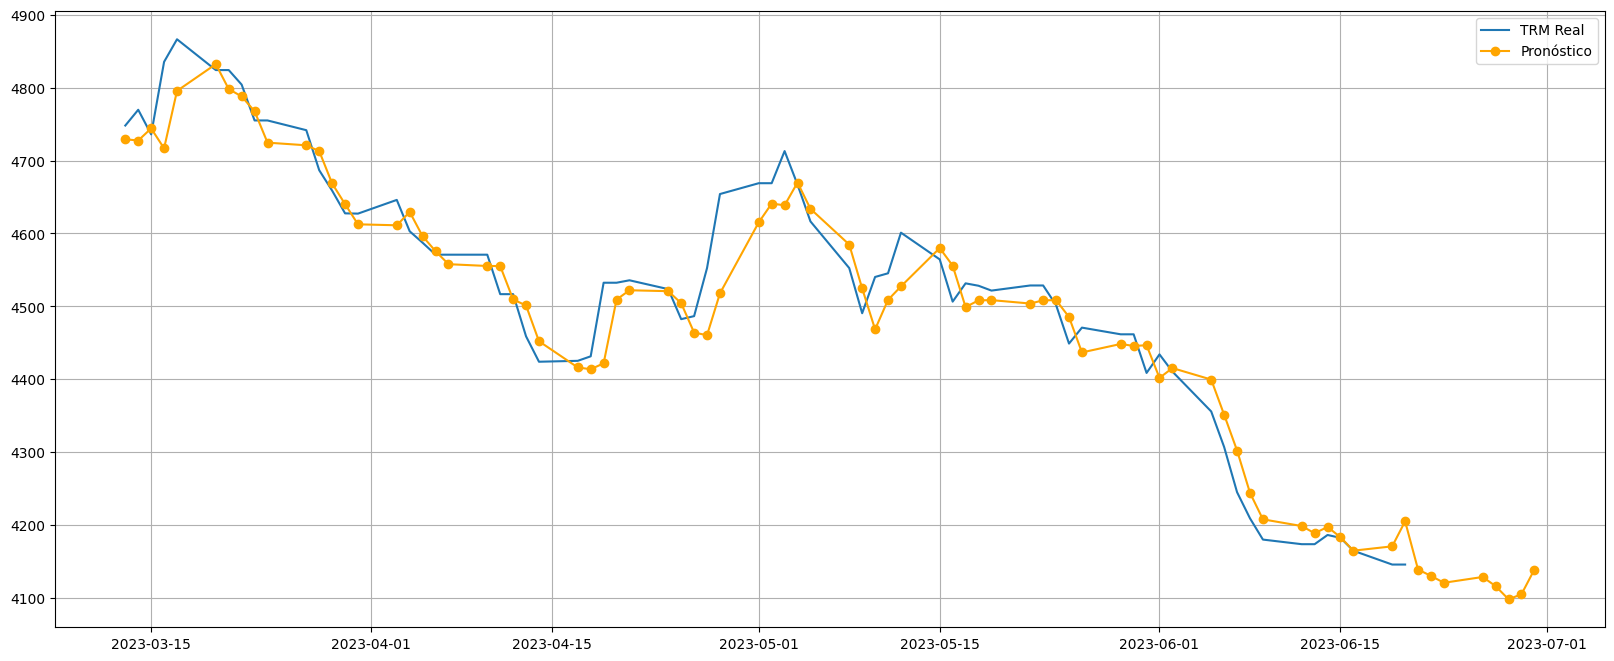

In [54]:
plt.figure(figsize=(20,8))
plt.plot(RvsM.loc[:,'TRM Real'],label='TRM Real')
#plt.scatter(x=RvsM.index,y=RvsM.loc[:,'TRM Modelo'],label='TRM Modelo',marker='o',color='orange')
plt.plot(tendencia,label='Pronóstico',marker='o',color='orange')
#plt.title('TRM_Modelo')
plt.legend()
plt.grid()
plt.show()
#plt.savefig('grafico.png')

In [56]:
with pd.ExcelWriter('/content/gdrive/MyDrive/Colab Notebooks/Kaggle/Real_modelo.xlsx') as writer:
  RvsM.to_excel(writer,sheet_name='Realidad Vs Modelo')
  TRM_CO.to_excel(writer,sheet_name='Pronostico')
